<a href="https://colab.research.google.com/github/mursaleen-sengr/Rumor-Classification-/blob/main/Main_FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
import random
# from collections import Counter

import warnings
warnings.filterwarnings("ignore")


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve,auc,recall_score,precision_score
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import LogisticRegression


In [ ]:
#dataset

df = pd.read_excel("DATASET_R1.xlsx")

In [ ]:
df.head()

,ID,Description,#Tweets,Date_time_creation_account,Language,#Followers,#Friends,Date&Time,#Favorite,#Retweet,Another Tweet Inside,Source,Tweet ID,Retweet ID,Quote ID,Reply ID,Frequency of tweet occurrences,State of Tweet
0,2752994783,// Kirby// they/them // 20 // ENG: ok // FR: ok,2822,"2014 , Aug , 28 , 01:49:22",en,34,68,"['2017', 'Dec', '15', '15:42:41']",0,250,0,iPhone,941695012122910720,940977667104477185,Not a quote,NaN,213.0,r
1,21571977,Follow us for the latest headlines across the ...,3085,"2009 , Feb , 22 , 15:32:48",en,21083,31,"['2017', 'Dec', '15', '15:37:51']",0,0,0,iPhone,941693798056280064,Not a Retweet,Not a quote,NaN,1,n
2,3382041618,Growing minds... Changing lives.,46,"2015 , Aug , 29 , 13:45:01",en,82,68,"['2017', 'Dec', '15', '15:37:37']",0,0,0,iPhone,941693735678758912,Not a Retweet,Not a quote,NaN,1,n
3,348478568,NaN,2007,"2011 , Aug , 04 , 14:08:52",en,26,270,"['2017', 'Dec', '15', '15:37:16']",0,0,0,Client,941693648634372097,Not a Retweet,Not a quote,NaN,1,n
4,724097168152367104,One does not simply un-FeelTheBern! 🔥,13050,"2016 , Apr , 24 , 04:46:32",en,166,287,"['2017', 'Dec', '15', '15:35:34']",0,151,0,iPhone,941693221704536064,941044904742006786,Not a quote,NaN,140.0,a


State of the tweet which can be one of the following forms (achieved by an agreement between the annotators) :

          r : The tweet/retweet is a rumor post

          a : The tweet/retweet is an anti-rumor post

          q : The tweet/retweet is a question about the rumor, however neither confirm nor deny it

          n : The tweet/retweet is not related to the rumor (even though it contains the queries related to the rumor, but does not refer                      to the rumor)

In [ ]:
df.isnull().sum()

ID                                   0
Description                       1011
#Tweets                              0
Date_time_creation_account           0
Language                             0
#Followers                           0
#Friends                             0
Date&Time                            0
#Favorite                            0
#Retweet                             0
Another Tweet Inside                 0
Source                               0
Tweet ID                             0
Retweet ID                           0
Quote ID                             0
Reply ID                          8118
Frequency of tweet occurrences       0
State of Tweet                       0
dtype: int64

In [ ]:
df.duplicated().value_counts()

False    8610
Name: count, dtype: int64

In [ ]:
df.shape

(8610, 18)

In [ ]:
df['State of Tweet'].value_counts()

State of Tweet
n    4517
a    3024
r    1020
q      49
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              8610 non-null   int64  
 1   Description                     7599 non-null   object 
 2   #Tweets                         8610 non-null   int64  
 3   Date_time_creation_account      8610 non-null   object 
 4   Language                        8610 non-null   object 
 5   #Followers                      8610 non-null   int64  
 6   #Friends                        8610 non-null   int64  
 7   Date&Time                       8610 non-null   object 
 8   #Favorite                       8610 non-null   int64  
 9   #Retweet                        8610 non-null   int64  
 10  Another Tweet Inside            8610 non-null   int64  
 11  Source                          8610 non-null   object 
 12  Tweet ID                        86

In [ ]:
# import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**Data Preprocessing and Vectorization:**

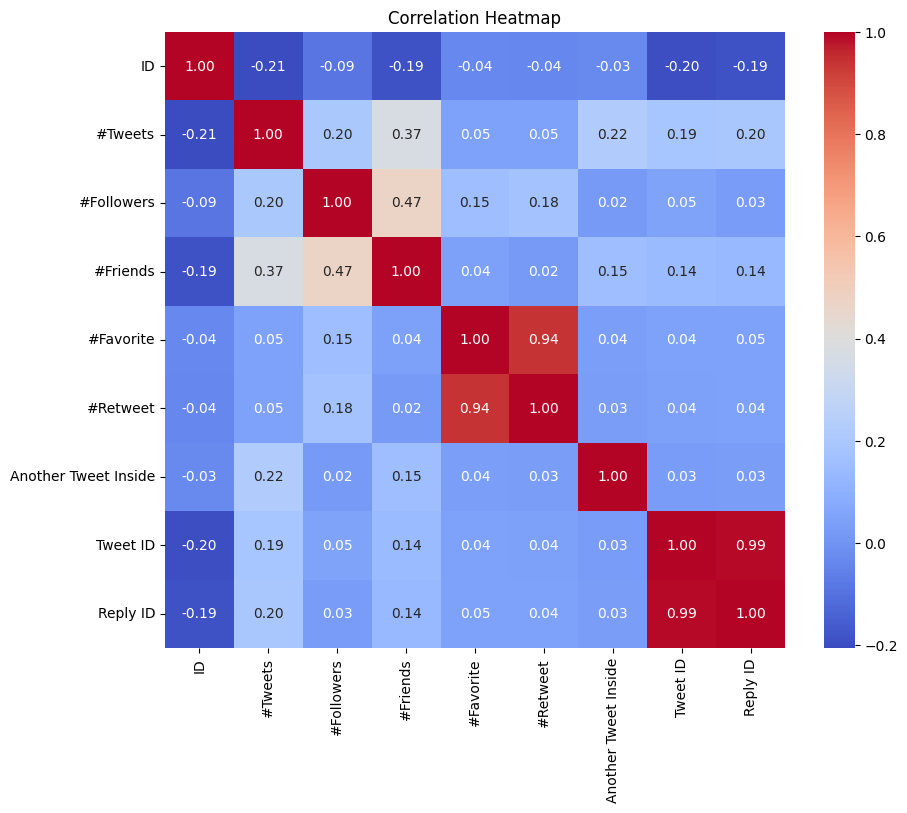

In [ ]:
# Handle missing values in the 'Description' column
# df['Description'].fillna('', inplace=True)

# Check for null values and remove them
df.dropna(inplace=True)
# Define a function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens]  # Remove punctuation and special characters
    stop_words = set(stopwords.words('english'))  # Get English stopwords
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()  # Initialize WordNetLemmatizer
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return ' '.join(tokens)  # Join tokens back into text

# Apply text preprocessing to the 'Description' column
df['Description'] = df['Description'].apply(preprocess_text)


# Vectorize text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['Description'])

# Vectorize text data using Bag of Words
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(df['Description'])

# Drop non-numeric columns before calculating the correlation matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

**Model Training and Evaluation:**

TF-IDF Vectorizer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['State of Tweet'], test_size=0.2, random_state=32)

In [ ]:
# Initialize and train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

In [ ]:
# Initialize and train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_pred = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)

In [ ]:
# Initialize and train Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

In [ ]:
# Initialize and train Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train, y_train)
gb_pred = gb_classifier.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

In [ ]:
print("SVM Accuracy:", svm_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Gradient Boosting Accuracy:", gb_accuracy)

SVM Accuracy: 0.8275862068965517
Naive Bayes Accuracy: 0.8275862068965517
Random Forest Accuracy: 0.8390804597701149
Gradient Boosting Accuracy: 0.7931034482758621


In [ ]:
svm_f1_score = f1_score(y_test, svm_pred, average='weighted')
nb_f1_score = f1_score(y_test, nb_pred, average='weighted')
rf_f1_score = f1_score(y_test, svm_pred, average='weighted')
gb_f1_score = f1_score(y_test, svm_pred, average='weighted')

In [ ]:
print("SVM f1_score:", svm_f1_score)
print("Naive Bayes f1_score:", nb_f1_score)
print("Random Forest f1_score:", rf_f1_score)
print("Gradient Boosting f1_score:", gb_f1_score)

SVM f1_score: 0.775429489556297
Naive Bayes f1_score: 0.7596731093052199
Random Forest f1_score: 0.775429489556297
Gradient Boosting f1_score: 0.775429489556297


**Bag of words**

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, df['State of Tweet'], test_size=0.2, random_state=2)

In [ ]:
# Initialize and train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_bow, y_train_bow)
svm_pred_bow = svm_classifier.predict(X_test_bow)
svm_accuracy_bow = accuracy_score(y_test_bow, svm_pred_bow)

In [ ]:
# Initialize and train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_bow, y_train_bow)
nb_pred_bow = nb_classifier.predict(X_test_bow)
nb_accuracy_bow = accuracy_score(y_test_bow, nb_pred_bow)

In [ ]:
# Initialize and train Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_bow, y_train_bow)
rf_pred_bow = rf_classifier.predict(X_test_bow)
rf_accuracy_bow = accuracy_score(y_test_bow, rf_pred_bow)

In [ ]:
# Initialize and train Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(X_train_bow, y_train_bow)
gb_pred_bow = gb_classifier.predict(X_test_bow)
gb_accuracy_bow = accuracy_score(y_test_bow, gb_pred_bow)

In [ ]:
print("SVM Accuracy:", svm_accuracy_bow)
print("Naive Bayes Accuracy:", nb_accuracy_bow)
print("Random Forest Accuracy:", rf_accuracy_bow)
print("Gradient Boosting Accuracy:", gb_accuracy_bow)

SVM Accuracy: 0.8390804597701149
Naive Bayes Accuracy: 0.6666666666666666
Random Forest Accuracy: 0.8505747126436781
Gradient Boosting Accuracy: 0.8390804597701149


In [ ]:
svm_bow_f1_score = f1_score(y_test_bow, svm_pred_bow, average='weighted')
nb_bow_f1_score = f1_score(y_test_bow, nb_pred_bow, average='weighted')
rf_bow_f1_score = f1_score(y_test_bow, rf_pred_bow, average='weighted')
gb_bow_f1_score = f1_score(y_test_bow, gb_pred_bow, average='weighted')

In [ ]:
print("SVM f1_score:", svm_bow_f1_score)
print("Naive Bayes f1_score:", nb_bow_f1_score)
print("Random Forest f1_score:", rf_bow_f1_score)
print("Gradient Boosting f1_score:", gb_bow_f1_score)

SVM f1_score: 0.7900972590627763
Naive Bayes f1_score: 0.7017994224076224
Random Forest f1_score: 0.8098998887652948
Gradient Boosting f1_score: 0.8010326387608334


**Visualization**

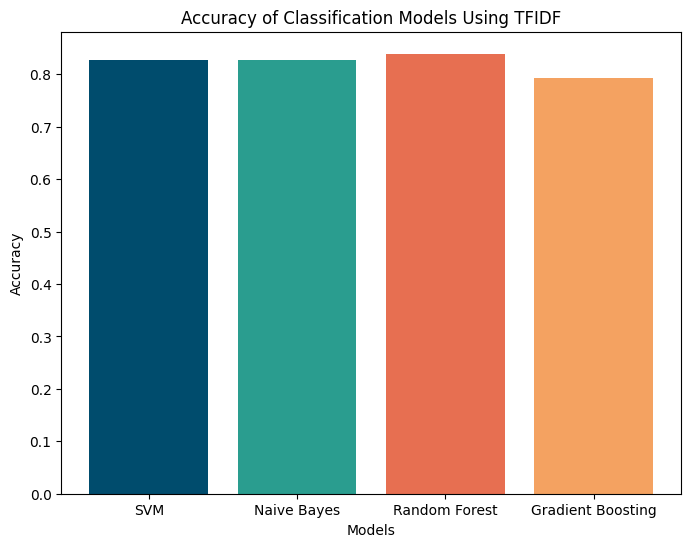

In [ ]:
# Plot model accuracies for TFIDF
models = ['SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting']
accuracies = [svm_accuracy, nb_accuracy, rf_accuracy, gb_accuracy]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#004c6d', '#2a9d8f', '#e76f51', '#f4a261'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classification Models Using TFIDF')
plt.show()

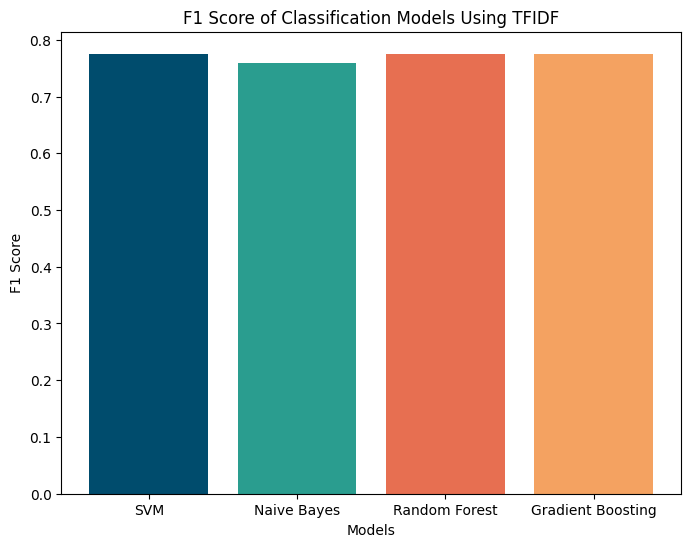

In [ ]:
# Plot model accuracies for TFIDF F1 score
models = ['SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting']
accuracies = [svm_f1_score, nb_f1_score, rf_f1_score, gb_f1_score]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#004c6d', '#2a9d8f', '#e76f51', '#f4a261'])
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score of Classification Models Using TFIDF')
plt.show()

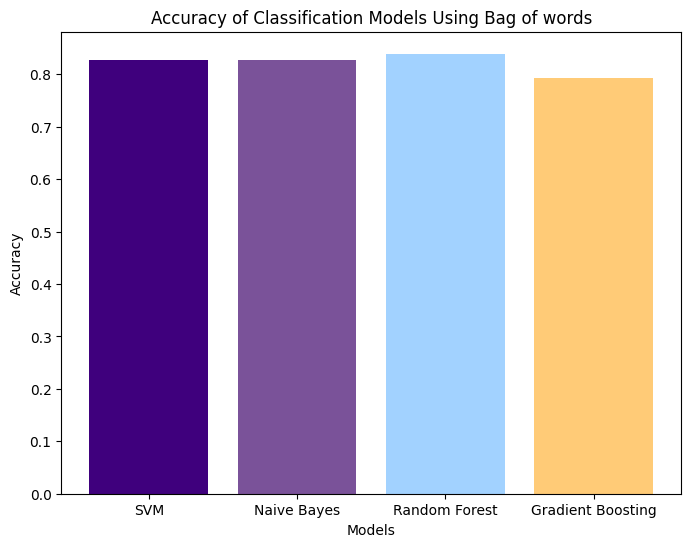

In [ ]:
# Plot model accuracies for Bag of words
models = ['SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting']
accuracies = [svm_accuracy, nb_accuracy, rf_accuracy, gb_accuracy]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#3f007d', '#7a5299', '#a2d2ff', '#ffcb77'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Classification Models Using Bag of words')
plt.show()

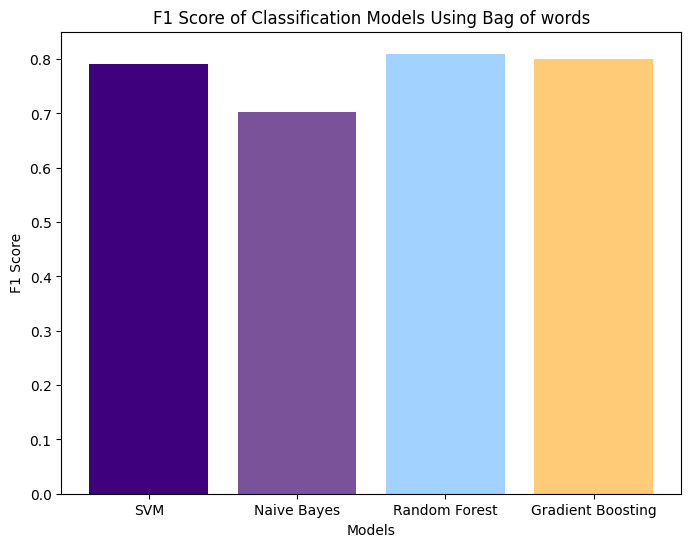

In [ ]:
# Plot model accuracies for Bag of words F1 score
models = ['SVM', 'Naive Bayes', 'Random Forest', 'Gradient Boosting']
accuracies = [svm_bow_f1_score, nb_bow_f1_score, rf_bow_f1_score, gb_bow_f1_score]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['#3f007d', '#7a5299', '#a2d2ff', '#ffcb77'])
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Score of Classification Models Using Bag of words')
plt.show()